#**Машинное обучение ИБ-2024**

#**Домашнее задание 1.**
#Регрессия, KNN, LinearRegression.

В данной домашней работе мы будем строить модели для предсказания цены квартиры в России. Ниже приведено описание некоторых колонок набора данных.

date - дата публикации объявления

price - цена в рублях

level- этаж, на котором находится квартира

levels - количество этажей в квартире

rooms - количество комнат в квартире. Если значение -1, то квартира считается апартаментами.

area - площадь квартиры.

kitchen_area - площадь кухни.

geo_lat - Latitude

geo_lon - Longitude

building_type - материал застройки. 0 - Don't know. 1 - Other. 2 - Panel. 3 - Monolithic. 4 - Brick. 5 - Blocky. 6 - Wooden

#Часть 0. Начало работы

Для начала работы с данными импортируем библиотеки, которые понадобятся в данном задании.

In [ ]:
import math
import pandas as pd
import numpy as np
import matplotlib as plt
import sklearn
import seaborn as sns

Загрузим библиотеку folium для отображения данных на карте по координатам.

In [ ]:
!pip install folium

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Распакуем наши данные из архива.

In [ ]:
!unzip /content/drive/MyDrive/archiveML.zip

Archive:  /content/drive/MyDrive/archiveML.zip
  inflating: input_data.csv          


Загрузим данные из csv файла в датафрейм.

In [ ]:
df = pd.read_csv("input_data.csv", sep=';')
print(df)

                date     price  level  levels  rooms  area  kitchen_area  \
0         2021-01-01   2451300     15      31      1  30.3           0.0   
1         2021-01-01   1450000      5       5      1  33.0           6.0   
2         2021-01-01  10700000      4      13      3  85.0          12.0   
3         2021-01-01   3100000      3       5      3  82.0           9.0   
4         2021-01-01   2500000      2       3      1  30.0           9.0   
...              ...       ...    ...     ...    ...   ...           ...   
11358145  2021-12-31   6099000      4       9      3  65.0           0.0   
11358146  2021-12-31   2490000      1      10      2  56.9           0.0   
11358147  2021-12-31    850000      2       2      2  37.0           5.0   
11358148  2021-12-31   4360000      5       5      1  36.0           9.0   
11358149  2021-12-31   1850000      1       5      1  33.0           7.0   

            geo_lat    geo_lon  building_type  object_type  postal_code  \
0         56

Отобразим на карте координаты наших построек.

In [ ]:
import folium
from IPython.display import display

map_df = df.loc[:1000]

m = folium.Map(location=[55.751244, 37.618423], zoom_start=10)

# Список точек с широтой и долготой
lats = map_df['geo_lat'].loc[:1000]
longs = map_df['geo_lon'].loc[:1000]
# Добавляем точки на карту
for point in zip(lats, longs):
    folium.Marker(
        location=[point[0], point[1]]
    ).add_to(m)

display(m)

# Часть 1. Подготовим данные для обработки моделями машинного обучения.

**0.5 Балл**. География наших наблюдений в наборе данных крайне большая. Однако мы знаем, что стоимость квартир в Москве и Санкт-Петербурге намного выше, чем в среднем по России. Давайте сделаем признаки, который показывают, находится ли квартира в 20 килиметрах от центра Москвы или находится ли квартира в 20 килиметрах от центра Санкт-Петербурга.

Создайте два признака is_Moscow и is_Saint_Peterburg. Для нахождения расстояния по координатам используйте функцию haversine_distance.

In [ ]:
def haversine_distance(lat1, lon1, lat2, lon2):
    lat1, lon1, lat2, lon2 = map(math.radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    return 2*6371*math.asin(math.sqrt(math.sin(dlat/2)**2 + math.cos(lat1)*math.cos(lat2)*math.sin(dlon/2)**2))

df['is_Moscow'] = df.apply(lambda row: haversine_distance(row['geo_lat'], row['geo_lon'], 55.755864, 37.617698) <= 20, axis=1)
df['is_Saint_Peterburg'] = df.apply(lambda row: haversine_distance(row['geo_lat'], row['geo_lon'], 59.938784, 30.314997) <= 20, axis=1)

**0.5 Балла**. В нашем наборе данных есть признаки, которые мы теоретически можем использовать, например postal_code, но мы это будем делать в рамках домашней работы очень-очень долго. Поэтому предлагается удалить ненужные признаки из датафрейма.

Удалим geo_lat,	geo_lon,	object_type,	postal_code,	street_id,	id_region,	house_id.

In [11]:
df = df.drop(columns=['geo_lat', 'geo_lon', 'object_type', 'postal_code', 'street_id', 'id_region', 'house_id'])
print(df)

                date     price  level  levels  rooms  area  kitchen_area  \
0         2021-01-01   2451300     15      31      1  30.3           0.0   
1         2021-01-01   1450000      5       5      1  33.0           6.0   
2         2021-01-01  10700000      4      13      3  85.0          12.0   
3         2021-01-01   3100000      3       5      3  82.0           9.0   
4         2021-01-01   2500000      2       3      1  30.0           9.0   
...              ...       ...    ...     ...    ...   ...           ...   
11358145  2021-12-31   6099000      4       9      3  65.0           0.0   
11358146  2021-12-31   2490000      1      10      2  56.9           0.0   
11358147  2021-12-31    850000      2       2      2  37.0           5.0   
11358148  2021-12-31   4360000      5       5      1  36.0           9.0   
11358149  2021-12-31   1850000      1       5      1  33.0           7.0   

          building_type  is_Moscow  is_Saint_Peterburg  
0                     0      F

**0.5 Балл**. Для начала Вам предлагается проанализировать Ваши оставшиеся признаки (колонки) в наборе данных. Какие колонки категориальные? Какие числовые?

Категориальные: building_type, is_Moscow, is_Saint_Peterburg

Числовые: date, price, level, levels, rooms, area, kitchen_area

Давайте закодируем категориальные признаки с помощью OneHot-Encoding. https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html

In [15]:
categorical_columns = ['building_type', 'is_Moscow', 'is_Saint_Peterburg']
import sklearn.preprocessing
encoder = sklearn.preprocessing.OneHotEncoder(sparse_output=False, handle_unknown='ignore')
encoder.fit(df.loc[:, categorical_columns])
encoded_feats = encoder.transform(df.loc[:, categorical_columns])
encoded_feats_names = encoder.get_feature_names_out(categorical_columns)
encoded_df = pd.DataFrame(encoded_feats, columns=encoded_feats_names, index=df.index)
df = pd.concat([df, encoded_df], axis=1)
df = df.drop(columns=categorical_columns)
print(df)

                date     price  level  levels  rooms  area  kitchen_area  \
0         2021-01-01   2451300     15      31      1  30.3           0.0   
1         2021-01-01   1450000      5       5      1  33.0           6.0   
2         2021-01-01  10700000      4      13      3  85.0          12.0   
3         2021-01-01   3100000      3       5      3  82.0           9.0   
4         2021-01-01   2500000      2       3      1  30.0           9.0   
...              ...       ...    ...     ...    ...   ...           ...   
11358145  2021-12-31   6099000      4       9      3  65.0           0.0   
11358146  2021-12-31   2490000      1      10      2  56.9           0.0   
11358147  2021-12-31    850000      2       2      2  37.0           5.0   
11358148  2021-12-31   4360000      5       5      1  36.0           9.0   
11358149  2021-12-31   1850000      1       5      1  33.0           7.0   

          building_type_0  building_type_1  building_type_2  building_type_3  \
0      

**0.5 Балл**. Поработаем с числовыми признаками:


1.   Добавьте в ваш датасет два признака: количество дней со дня первого наблюдения (разница между датами объявлений). Возможно, для предсказания цены не так важен этаж, как важно отношение этажа квартиры на количество этажей в доме, добавьте этот признак. После добавления нового признака колонку date можно удалить.
2.   Числовые признаки могут иметь разные порядки. Давайте отнормируем числовые признаки с помощью StandartScaller https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html.



In [ ]:
df['date'] = pd.to_datetime(df['date'])
first_observ = df['date'].min()
df['days_since_first_observ'] = (df['date'] - first_observ).dt.days
df = df.drop(columns=['date'])

df['floor_att'] = df.apply(lambda row: row['level']/row['levels'] if row['levels'] else 1., axis=1)
df = df.drop(columns=['level', 'levels'])
print(df)

In [25]:
# нормировка
numeric_columns = ['price', 'level', 'levels', 'rooms', 'area', 'kitchen_area', 'days_since_first_observ', 'floor_att']
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(df.loc[:, numeric_columns])
df.loc[:, numeric_columns] = scaler.transform(df.loc[:, numeric_columns])
df.loc[:, numeric_columns] = df.loc[:, numeric_columns].astype(np.float64)
print(df)

             price     rooms      area  kitchen_area  building_type_0  \
0        -0.021932 -0.621470 -0.840577      0.082486              1.0   
1        -0.026996 -0.621470 -0.741051      0.267565              1.0   
2         0.019789  1.106234  1.175756      0.452644              0.0   
3        -0.018651  1.106234  1.065171      0.360105              1.0   
4        -0.021686 -0.621470 -0.851636      0.360105              0.0   
...            ...       ...       ...           ...              ...   
11358145 -0.003482  1.106234  0.438523      0.082486              1.0   
11358146 -0.021736  0.242382  0.139943      0.082486              1.0   
11358147 -0.030031  0.242382 -0.593604      0.236719              1.0   
11358148 -0.012278 -0.621470 -0.630466      0.360105              1.0   
11358149 -0.024973 -0.621470 -0.741051      0.298412              1.0   

          building_type_1  building_type_2  building_type_3  building_type_4  \
0                     0.0              0.0 

**2 Балла**. Реализуйте класс KNNRegressor, который должен делать регрессию методом k ближайших соседей.

In [26]:
class KNNRegressor:
    def __init__(self, n_neighbors=5, metric='euclidean'):
      self.nn = n_neighbors
      self.metric = metric

    def fit(self, X, y):
      self.X = X
      self.y = y

    def predict(self, X):
      predictions = []
      for x in X:
        if self.metric == 'euclidean':
          distances = [np.sqrt(np.sum((x - x_train)**2)) for x_train in self.X]
        else:
          raise ValueError("use 'euclidean' metric")
        k_indices = np.argsort(distances)[:self.nn]
        k_nearest_labels = [self.y[i] for i in k_indices]
        prediction = np.mean(k_nearest_labels)
        predictions.append(prediction)
      return np.array(predictions)

In [31]:
knn_obj = KNNRegressor(n_neighbors=3, metric='euclidean')
knn_obj.fit(
    np.array([[1], [2], [3], [4], [5]]),
    np.array([0, 1.5, 3, 4.5, 6])
)
predicts = knn_obj.predict(np.array([[0.5], [2.5], [3.5]]))
print(predicts)
del knn_obj, encoded_df, encoded_feats_names, encoded_feats, categorical_columns, encoder, scaler, numeric_columns, first_observ

[1.5 1.5 3. ]


**3 Балла**. Реализуйте класс LinearRegression, поддерживающий обучение градиентными спусками SGD, Momentum, AdaGrad. Используйте градиент для оптимизации функции потерь MSE.

In [40]:
class LinearRegression:
    def __init__(self, learning_rate=0.01, optimization='SGD', epsilon=1e-8, decay_rate=0.9, max_iter=1000):
        self.learning_rate = learning_rate
        self.optimization = optimization
        self.epsilon = epsilon
        self.decay_rate = decay_rate
        self.max_iter = max_iter
        self.weights = None
        self.bias = None

    def fit(self, X, y):
        samples_num, feats_num = X.shape
        self.weights = np.zeros(feats_num)
        self.bias = 0
        if self.optimization == 'SGD':
          for k in range(self.max_iter):
            for i in range(samples_num):
                y_pred = np.dot(X[i], self.weights) + self.bias
                dw = (y_pred - y[i]) * X[i]
                db = (y_pred - y[i])
                self.weights -= self.learning_rate * dw
                self.bias -= self.learning_rate * db
        elif self.optimization == 'Momentum':
          velocity_w = np.zeros_like(self.weights)
          velocity_b = 0
          for k in range(self.max_iter):
              for i in range(samples_num):
                  y_pred = np.dot(X[i], self.weights) + self.bias
                  dw = (y_pred - y[i]) * X[i]
                  db = (y_pred - y[i])
                  velocity_w = self.decay_rate * velocity_w + self.learning_rate * dw
                  velocity_b = self.decay_rate * velocity_b + self.learning_rate * db
                  self.weights -= velocity_w
                  self.bias -= velocity_b
        elif self.optimization == 'AdaGrad':
          squared_sum_w = np.zeros_like(self.weights)
          squared_sum_b = 0
          for _ in range(self.max_iter):
              for i in range(samples_num):
                  y_pred = np.dot(X[i], self.weights) + self.bias
                  dw = (y_pred - y[i]) * X[i]
                  db = (y_pred - y[i])
                  squared_sum_w += dw**2
                  squared_sum_b += db**2
                  self.weights -= self.learning_rate * dw / (np.sqrt(squared_sum_w) + self.epsilon)
                  self.bias -= self.learning_rate * db / (np.sqrt(squared_sum_b) + self.epsilon)
        else:
          raise ValueError("use 'SGD', 'Momentum' or 'AdaGrad' optimization")

    def predict(self, X):
        return np.dot(X, self.weights) + self.bias

# Часть 2. Эксперименты с моделями машинного обучения.

**3 Балла**. Проведите эксперименты с написанными Вами методами машинного обучения. Выделите обучающую и тестовую выборки в отношении 0,8 и 0,2 соответственно. Измерьте ошибку MSE, MAE, RMSE. Заиспользуйте методы KNNRegressor и LinearRegression из библиотеки sklearn, сравните качество Ваших решений и библиотечных.

Здесь задаётся часть выборки (целую было бы слишком долго считать, а я вспомнил о домашке за 5 часов до дедлайна, будучи на работе), которая выбирается случайным образом:

In [61]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error


percentile = 0.001
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns=['price']),
                                                    df['price'],
                                                    test_size=0.2 * percentile,
                                                    train_size=0.8*percentile,
                                                    random_state=42)
# df_part = df.loc[:1000]
# X = df_part.drop(columns=['price'])
# y = df_part['price']
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Здесь создаётся экземпляр моего класса регрессии методом K-ближайших соседей, далее модель обучается на тренировочной выборке и обрабатывает тестовую. После этого вычисляются и выводятся в консоль метрики.

In [62]:
my_knn = KNNRegressor(n_neighbors=5, metric='euclidean')
my_knn.fit(X_train.values, y_train.values)
my_knn_pred = my_knn.predict(X_test.values)

my_knn_mse = mean_squared_error(y_test, my_knn_pred)
my_knn_mae = mean_absolute_error(y_test, my_knn_pred)
my_knn_rmse = np.sqrt(my_knn_mse)

print("MSE:", my_knn_mse)
print("MAE:", my_knn_mae)
print("RMSE:", my_knn_rmse)

MSE: 0.8819584246891725
MAE: 0.03784904430294182
RMSE: 0.9391264157125879


Здесь происходит то же самое, но обучается модель регрессии KNN из библиотеки Sklearn.

In [63]:
from sklearn.neighbors import KNeighborsRegressor

sk_knn = KNeighborsRegressor(n_neighbors=5, metric='euclidean')
sk_knn.fit(X_train.values, y_train.values)
sk_knn_pred = sk_knn.predict(X_test.values)

sk_knn_mse = mean_squared_error(y_test, sk_knn_pred)
sk_knn_mae = mean_absolute_error(y_test, sk_knn_pred)
sk_knn_rmse = np.sqrt(sk_knn_mse)

print("MSE:", sk_knn_mse)
print("MAE:", sk_knn_mae)
print("RMSE:", sk_knn_rmse)

MSE: 0.8819584246891725
MAE: 0.03784904430294182
RMSE: 0.9391264157125879


Здесь обучается моя модель линейной регрессии и для неё вычисляются метрики.

In [64]:
my_lin = LinearRegression(optimization='SGD')
my_lin.fit(X_train.values, y_train.values)
my_lin_pred = my_lin.predict(X_test.values)

my_lin_mse = mean_squared_error(y_test, my_lin_pred)
my_lin_mae = mean_absolute_error(y_test, my_lin_pred)
my_lin_rmse = np.sqrt(my_lin_mse)

print("MSE:", my_lin_mse)
print("MAE:", my_lin_mae)
print("RMSE:", my_lin_rmse)

MSE: 0.8815716718170606
MAE: 0.04121799325822811
RMSE: 0.9389204821586654


Здесь обучается модель линейной регрессии из sklearn и вычисляются метрики для неё.

In [65]:
from sklearn.linear_model import LinearRegression as SklearnLinearRegression

sk_lin = SklearnLinearRegression()
sk_lin.fit(X_train.values, y_train.values)
sk_lin_pred = sk_lin.predict(X_test.values)

sk_lin_mse = mean_squared_error(y_test, sk_lin_pred)
sk_lin_mae = mean_absolute_error(y_test, sk_lin_pred)
sk_lin_rmse = np.sqrt(sk_lin_mse)

print("MSE:", sk_lin_mse)
print("MAE:", sk_lin_mae)
print("RMSE:", sk_lin_rmse)

MSE: 0.8810862639892011
MAE: 0.04241661313887642
RMSE: 0.9386619540543875


Для 0.001 от размера выборки я посчитал все метрики и вот краткая сводка в виде таблицы:
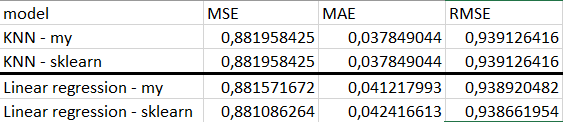